In [1]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import io
from PIL import Image
import glob
import os
import pandas as pd
import matplotlib
matplotlib.style.use('dark_background')
import re
import seaborn as sns
import sys
from datetime import datetime, timedelta
from sklearn.linear_model import LogisticRegression
sys.path.append('E:/')
from function import *
import h5py

In [2]:
# Main processing loop for multiple files
pc = 'PC'
if pc == 'PC':
    basevol='E:/sophia'
else:
    basevol = 'D:/sophia'
    
basepath = basevol + '/shark_data/'
output_folder = basepath + "processed_data/"
npz_directory = basepath + 'data/'
figures_path = basepath + "figures/"
output_folder = basepath + "processed_data/"
npz_directory = basepath + 'data/'
figures_path = basepath + "figures/"

In [3]:
sharks_speed = pd.read_hdf(output_folder + "speed_sharks.h5", key='sharks')
data = pd.read_hdf(output_folder + "heading_sharks.h5", key='sharks')
data = pd.merge(data, sharks_speed[['Trial', 'ID', 'frame','standardized_speed']], on=['Trial', 'ID', 'frame'], how='left')
data.head()

,index,SPEED#wcentroid,ID,X#pcentroid,Y#pcentroid,ANGLE,frame,time,headx,heady,...,segment,Trial,midpoint_x,midpoint_y,carangids,drone_movement,ID_checked,heading,angular_velocity,standardized_speed
0,0,0.000000,0,NaN,NaN,-0.263183,0,0.00,2044.00,685.000000,...,1,sequence_20240303_060726300_DJI_0242,1999.000000,695.000000,0,0,1.0,-0.218669,NaN,-0.010231
1,1,55.754349,0,NaN,NaN,-0.253584,1,0.01,2045.00,685.000000,...,1,sequence_20240303_060726300_DJI_0242,1999.750000,695.000000,0,0,1.0,-0.217499,0.058514,-0.010228
2,2,103.976613,0,NaN,NaN,-0.245468,2,0.02,2046.00,684.333333,...,1,sequence_20240303_060726300_DJI_0242,2000.333333,694.666667,0,0,1.0,-0.222530,-0.251563,-0.010222
3,3,123.176350,0,NaN,NaN,-0.238684,3,0.03,2047.75,684.000000,...,1,sequence_20240303_060726300_DJI_0242,2001.375000,694.750000,0,0,1.0,-0.227783,-0.262649,-0.010210
4,4,126.865948,0,NaN,NaN,-0.233522,4,0.04,2049.20,683.800000,...,1,sequence_20240303_060726300_DJI_0242,2002.500000,694.800000,0,0,1.0,-0.231329,-0.177323,-0.010195


### log Regression

In [4]:
data = data[data['standardized_speed'].notna() & ~np.isinf(data['standardized_speed'])]

# Step 1: Randomly sample 60 unique segments from the 'segment' column
unique_segments = data['segment'].drop_duplicates().sample(n=60, replace=False)

# Step 2: Filter the rows that correspond to the randomly selected unique segments
sampled_data = data[data['segment'].isin(unique_segments)]

# Step 3: Group by 'segment' and count the rows per segment
grouped_counts = sampled_data.groupby('segment').size()

# Step 4: Filter out segments with counts over 5000 or under 300
valid_segments = grouped_counts[(grouped_counts >= 1000)].index

# Step 5: Filter the sampled data to keep only those segments with valid row counts
sampledata = sampled_data[sampled_data['segment'].isin(valid_segments)]
sampledata = sampledata[sampledata['standardized_speed'].notna() & ~np.isinf(data['standardized_speed'])]

# Display the final sampled data and the count of rows per segment
print(sampledata.groupby('segment').size())


segment
1      80481
2      13413
3      38978
4      22097
5      37151
6      18130
7      14377
9      19965
11      4800
12     30550
14     31215
15     14571
16     21319
18     20898
19      8782
20      1117
22     20385
23     10826
24     16446
27     11100
28      6555
29      8019
31      6984
33     11809
35      1972
36     19771
38      5492
39     14948
40     10542
43      1199
44      2696
52      3374
55      1989
57     12012
59     42441
60     13590
61     25603
70      1393
71      2702
75      2499
84      3615
86      2349
88      3384
504     8545
dtype: int64


C:\Users\sophi\AppData\Local\Temp\ipykernel_23576\221949909.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sampledata = sampledata[sampledata['standardized_speed'].notna() & ~np.isinf(data['standardized_speed'])]


C:\Users\sophi\miniforge3\envs\data_analysis\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


(array([2.00000e+01, 6.00000e+00, 7.70000e+01, 3.23000e+02, 1.69310e+04,
        1.74685e+05, 3.64152e+05, 8.39760e+04, 9.19800e+03, 3.42000e+02]),
 array([-9.32411974, -7.84980141, -6.37548308, -4.90116475, -3.42684642,
        -1.95252809, -0.47820977,  0.99610856,  2.47042689,  3.94474522,
         5.41906355]),
 <BarContainer object of 10 artists>)

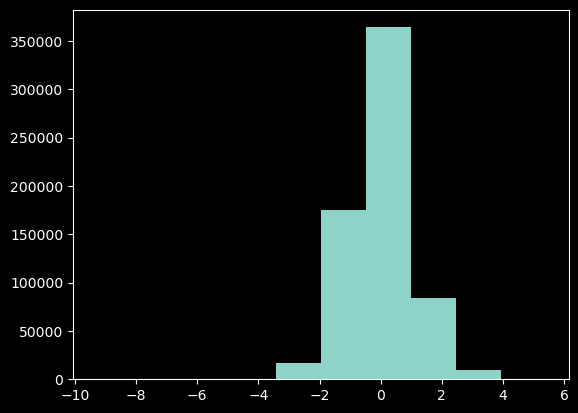

In [28]:
from sklearn.preprocessing import StandardScaler
sampledata['log_speed']= np.log(sampledata['standardized_speed'])
scaler = StandardScaler()
sampledata['log_speed_scaled']=scaler.fit_transform(sampledata[['log_speed']])
plt.hist(sampledata['log_speed_scaled'])

In [82]:
# Parameters
context_timesteps = 50
future_timesteps = 10
num_features = 2  # Speed and Angular Velocity

# Create a dictionary to store sequences
data_dict = {}

# Get unique segment IDs from your data (this will handle up to 1000 segments or more)
segment_ids = sampledata["segment"].unique()

for segment_id in segment_ids:
    segment_data = sampledata[sampledata["segment"] == segment_id].sort_values(by="frame")
    
    # Ensure segment has enough frames to extract both context and future sequences
    segment_length = len(segment_data)
    if segment_length < (context_timesteps + future_timesteps):
        print(f"Skipping segment {segment_id} due to insufficient frames.")
        continue  # Skip segments that are too short
    
    # Calculate max valid start index (must leave space for context and future)
    max_start_index = segment_length - (context_timesteps + future_timesteps)
    
    # If the segment length is exactly the required size, only start at index 0
    if max_start_index < 0:
        print(f"Skipping segment {segment_id} due to inadequate frame space.")
        continue
    
    # Randomly select a starting frame ensuring enough space for both context and future steps
    start_idx = np.random.randint(0, max_start_index + 1)
    
    # Extract context and future sequences
    context = segment_data.iloc[start_idx:start_idx + context_timesteps][["log_speed_scaled", "angular_velocity"]].values
    positive = segment_data.iloc[start_idx + context_timesteps:start_idx + context_timesteps + future_timesteps][["log_speed_scaled", "angular_velocity"]].values
    
   # Generate negative future sequence with random values
    negative_future = np.random.normal(scale=5, size=(future_timesteps, num_features))

    # Combine context + future timesteps
    negative = np.concatenate((context, negative_future), axis=0)

    # Flatten for model input
    positive_input = np.concatenate((context, positive), axis=0).flatten()
    negative_input = negative.flatten()  # This keeps real context and only randomizes future

    # Store in dictionary
    data_dict[segment_id] = {
        "context": context,
        "positive_input": positive_input,
        "negative_input": negative_input}

# Convert dictionary to DataFrame
processed_df = pd.DataFrame.from_dict(data_dict, orient="index")

# Output the shapes of one pair to check
positive_input.shape, negative_input.shape


((120,), (120,))

In [83]:
all_positive_inputs = []
all_negative_inputs = []

for segment_id in segment_ids:
    if segment_id in data_dict:  # Ensuring only processed segments are included
        all_positive_inputs.append(data_dict[segment_id]["positive_input"])
        all_negative_inputs.append(data_dict[segment_id]["negative_input"])

# Convert lists to NumPy arrays
all_positive_inputs = np.array(all_positive_inputs)  # Shape: (num_segments, 120)
all_negative_inputs = np.array(all_negative_inputs)  # Shape: (num_segments, 120)

# Stack along a new axis to create (num_segments, 2, 120)
input_features = np.stack([all_positive_inputs, all_negative_inputs], axis=1)

print(f"Input features shape: {input_features.shape}")  # Should be (60, 2, 120)

Input features shape: (44, 2, 120)


In [84]:
# Assuming `all_positive_inputs` and `all_negative_inputs` are already collected
all_positive_inputs = np.array(all_positive_inputs)  # Shape: (60, 120)
all_negative_inputs = np.array(all_negative_inputs)  # Shape: (60, 120)

# Stack them in pairs (positive, negative) and then flatten
input_features = np.stack([all_positive_inputs, all_negative_inputs], axis=1)  # Shape: (60, 2, 120)

# Flatten the second axis (pair axis) so that we get the shape [pair, vector] 
input_features = input_features.reshape(-1, input_features.shape[-1])  # Shape: (120, 120)

print(f"Flattened input features shape: {input_features.shape}")


Flattened input features shape: (88, 120)


In [85]:
labels = np.array([1, 0]*44)

In [86]:
model = LogisticRegression(penalty=None)
model.fit(input_features, labels)

C:\Users\sophi\miniforge3\envs\data_analysis\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(penalty=None)

In [87]:
posterior_probability = model.predict_proba(input_features)
log_likelihood_ratio = model.decision_function(input_features)

In [88]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

In [89]:
sigmoid(log_likelihood_ratio), 1 - sigmoid(log_likelihood_ratio)

(array([9.74208915e-01, 2.85714418e-02, 5.94808194e-01, 4.21346779e-01,
        7.71375321e-01, 2.24973631e-01, 8.00327090e-01, 4.25844556e-02,
        9.84100862e-01, 3.00869888e-02, 9.47996324e-01, 8.51391426e-02,
        3.23538250e-01, 7.76916355e-01, 4.39278629e-01, 5.76506334e-01,
        9.65233075e-01, 8.36299944e-02, 7.83946389e-01, 2.10277016e-01,
        4.36281274e-01, 5.67649859e-01, 9.36684295e-01, 5.13282873e-02,
        5.39808354e-01, 4.07093943e-01, 9.22659461e-01, 6.38996330e-02,
        9.10626237e-01, 1.68469719e-01, 8.91719541e-01, 1.34673438e-01,
        8.69120536e-01, 2.50202452e-01, 6.94236058e-01, 2.54360134e-01,
        9.45470721e-01, 3.23185953e-04, 3.88801841e-01, 5.49353782e-01,
        8.73496007e-01, 1.49653334e-01, 8.44106912e-01, 1.86520951e-01,
        1.01353643e-01, 9.59392510e-01, 9.51334977e-01, 2.40223659e-02,
        9.93758833e-01, 1.39530072e-02, 8.47555371e-01, 2.25328490e-01,
        9.87228664e-01, 1.10417298e-01, 8.42278783e-01, 5.054259

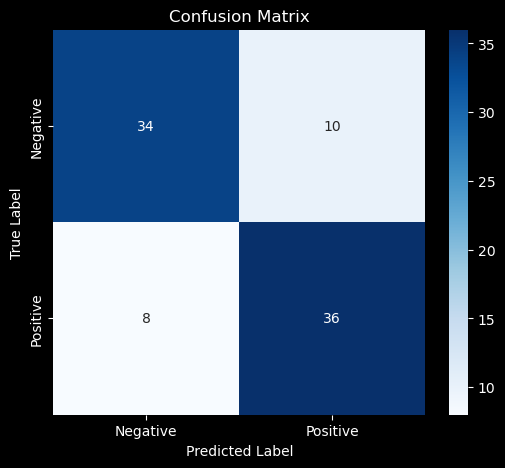

Model Accuracy: 0.7955


In [90]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

# Get predictions
y_pred = model.predict(input_features)

# Compute confusion matrix
cm = confusion_matrix(labels, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print accuracy
accuracy = accuracy_score(labels, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")


In [ ]:
# Group by Trial ID and extract 50 consecutive frames for each trial
context_data = {}

for (trial_id, segment_id, fish_id), trial_data in data.groupby(['Trial', 'segment', 'ID']):
    trial_data = trial_data.sort_values(by='frame')  # Ensure frames are in order
    
    # Only consider segments with at least 50 frames
    if len(trial_data) >= 300:
        # Randomly select a valid start index
        start_idx = np.random.randint(0, len(trial_data) - 50 + 1)
        
        # Extract 50 consecutive frames
        selected_frames = trial_data.iloc[start_idx:start_idx + 50]
        
        # Store Speed & AngularVelocity values in a NumPy array (shape: 50, 2)
        context_data[(trial_id, segment_id, fish_id)] = selected_frames[['standardized_speed', 'angular_velocity']].to_numpy()

# Example: Access context data for a specific (Trial, Segment) pair
example_key = list(context_data.keys())[0]
print(f"Trial ID: {example_key[0]}, Segment ID: {example_key[1]}, Context Shape: {context_data[example_key].shape}")